In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm

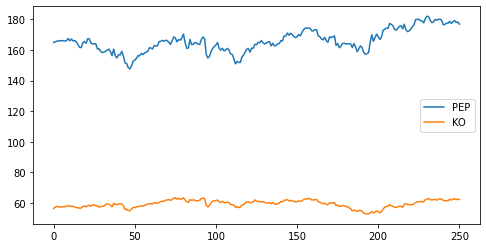

In [3]:
#plot the two assets
asset_1 = pd.read_csv('pepsi_df.csv')
asset_2 = pd.read_csv('coke_df.csv')
PEP = asset_1['Close']
KO = asset_2['Close']

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(PEP, label = 'PEP')
ax.plot(KO, label = 'KO')
ax.legend()
plt.show()

In [4]:
#we can see that PEP and KO roughly move together, but because of price difference, PEP is moving a lot more than KO
print('PEP mean is ' + str(np.mean(PEP)))
print('KO mean is ' + str(np.mean(KO)))

PEP mean is 165.91812006125886
KO mean is 59.29993294339731


Coefficient is 0.14956024905256626


c:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<AxesSubplot:>

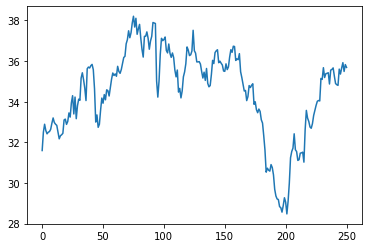

In [16]:
#Each of PEP's movements will be approximately 2.5 times greater than KO, so we can address this by using linear regression to calculate a coefficient for the linear combination between PEP and KO
PEP = sm.add_constant(PEP)
results = sm.OLS(KO, PEP).fit()
PEP = PEP['Close']
b = results.params['Close']
print('Coefficient is ' + str(b))

spread = KO - PEP * b
spread.plot()